In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Esercitazione 7

Esercizio 7.2 è su data blocking e autocorrelazione, Esercizio 7.4 è sulla gofr. Per ogni stato ho fatto entrambi gli esercizi. Nel primo faccio prima giro con tot passi (tipo 6000), controllo accettazione fissando il delta per averla del 50% e poi rifaccio equilibrazione (600) più 5*1e5 passi con la delta giusta. Lo stesso valore fissato poi lo uso per le simulazioni della parte sulla gofr. Attenzione:equilibrazione con dinamica molecolare è diversa!

In [2]:
#implementazione del calcolo della funzione di autocorrelazione dato un array di misure mis e un tempo t
def AutoCorr(mis, t):
    t_max=len(mis)
    #sommatorie della formula nell'ordine in cui compaiono, con già la normalizzazione
    sum1=np.mean(mis[:t_max-t]*mis[t:t_max])
    sum2=np.mean(mis[:(t_max-t)])
    sum3=np.mean(mis[t:t_max])
    sum4=np.mean(mis*mis)
    sum5=np.mean(mis)
    return (sum1-(sum2*sum3))/(sum4-(sum5**2))

#errore a blocchi larghi L passi su un array di dati mis, ritorna media e errore all'ultimo blocco
def BlockAnalysis(mis, L):
    if L==0:
        raise ValueError("Errore: la larghezza dei blocchi non può essere zero.")
    B=len(mis)//L  #numero di blocchi
    if len(mis)%B != 0:
        raise ValueError("Attenzione: il numero di blocchi inserito non è divisore del numero di lanci totale.")
    mis_blocks=np.reshape(mis[:B*L], (B, L))  #creo B vettori da L elementi
    #medie per ogni blocco
    mean_block=np.mean(mis_blocks, axis=1)
    mean_block2=mean_block*mean_block
    #medie considerando tutti i blocchi
    mean_tot=np.sum(mean_block)/B
    mean_tot2=np.sum(mean_block2)/B
    #errore all'ultimo blocco
    fin_error=np.sqrt((mean_tot2 - mean_tot**2)/B)
    return fin_error   

In [3]:
#variabili utilizzate

Neq=600  #passi della simulazione di equilibrazione
xeq=np.arange(Neq)  #plotto in base agli steps, non faccio media a blocchi
Nan=500000  #passi della simulazione di analisi
xan=np.arange(Nan)  #plotto in base agli steps, non faccio media a blocchi
Ls=np.array([x for x in range(10,5001) if (Nan%x ==0)]) #divisori di 500000 che uso come larghezza dei blocchi
ts=xan[:800]  #valori di t per cui valuto autocorrelazione

Nbl=50  #numero blocchi analisi gofr
xbl=np.arange(Nbl)+1

# Stato solido 

## Data blocking e autocorrelazione 

In [4]:
sol_inst=np.loadtxt("SolidState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

In [5]:
sol_ac=np.empty(len(ts))
for i in range(len(ts)):
    sol_ac[i]=AutoCorr(sol_inst, ts[i])

In [6]:
sol_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    sol_error[i]=BlockAnalysis(sol_inst, Ls[i])

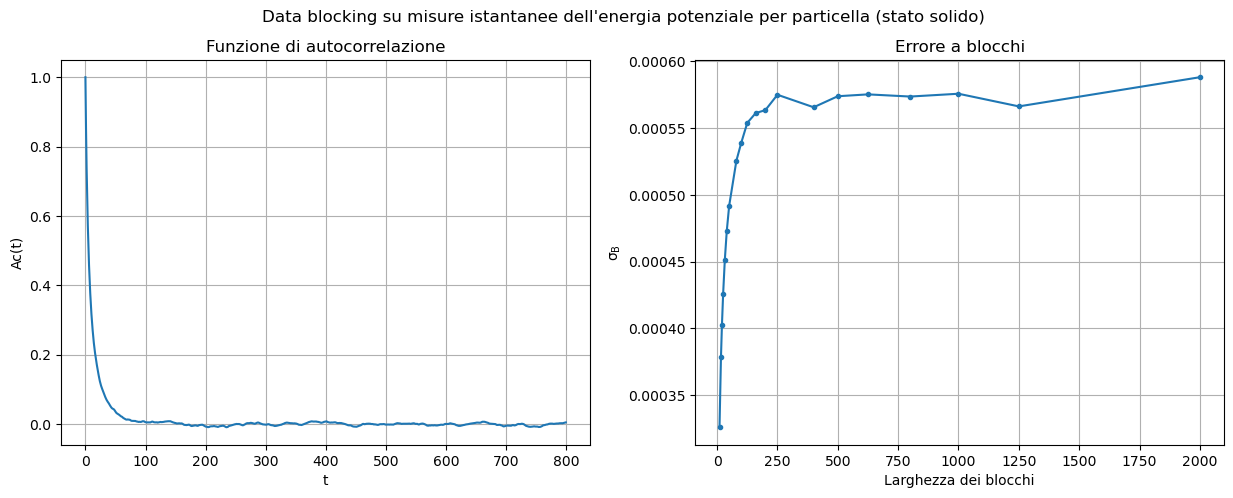

In [26]:
sbfig ,(sbplt1, sbplt2) = plt.subplots(1, 2, figsize=(15, 5))

sbplt1.plot(ts, sol_ac)
sbplt1.set_xlabel("t")
sbplt1.set_ylabel("Ac(t)")
sbplt1.set_title("Funzione di autocorrelazione")
sbplt1.grid(True)

sbplt2.plot(Ls[:20], sol_error[:20], marker='.')
sbplt2.set_xlabel("Larghezza dei blocchi")
sbplt2.set_ylabel(r"$\mathrm{\sigma_B}$")
sbplt2.set_title("Errore a blocchi")
sbplt2.grid(True)

sbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato solido)")
plt.show()

Qua (e sotto) l'importante è che ci sia un simil plateau dell'errore dopo zero in corrispondenza del calo dell'autocorrelazione. Poi fa cose strane forse anche perchè inizia ad avere pochi blocchi su cui fare l'errore. Può aver senso, soprattutto nel caso del gas che ha autocorrelazione che cade molto prima, plottare solo i primi valori e non arrivare fino a 5000.

## Gofr

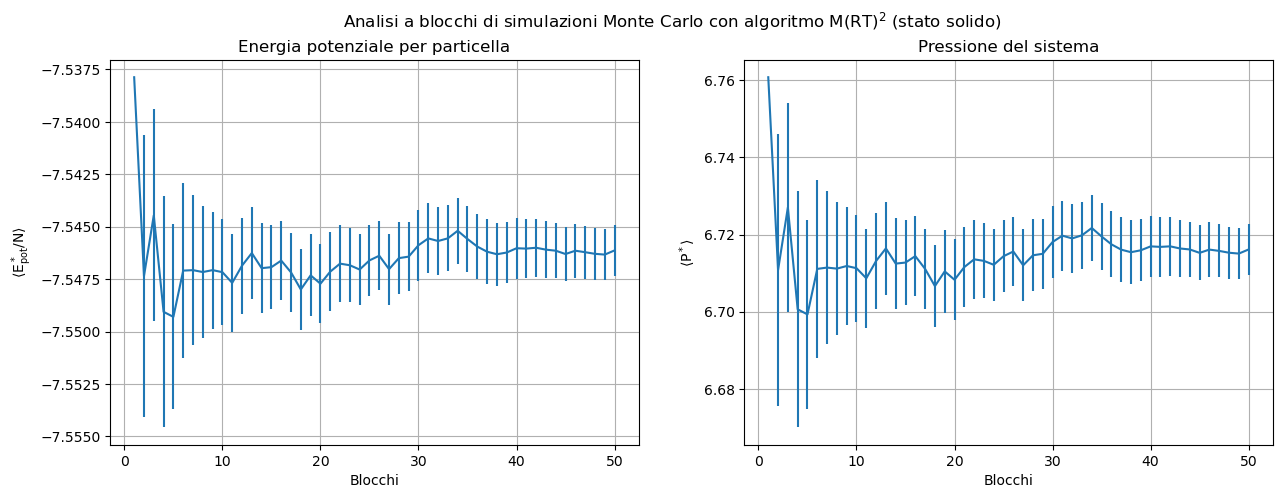

In [8]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
sol_en, sol_en_err=np.loadtxt("SolidState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
sol_pres, sol_pres_err=np.loadtxt("SolidState/pressure.dat", usecols=(2, 3), unpack="true")

smfig ,(smplt1, smplt2) = plt.subplots(1, 2, figsize=(15, 5))

smplt1.errorbar(xbl, sol_en, yerr=sol_en_err)
smplt1.set_xlabel("Blocchi")
smplt1.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
smplt1.set_title("Energia potenziale per particella")
smplt1.grid(True)

smplt2.errorbar(xbl, sol_pres, yerr=sol_pres_err)
smplt2.set_xlabel("Blocchi")
smplt2.set_ylabel(r"$\langle \mathrm{P^*} \rangle$")
smplt2.set_title("Pressione del sistema")
smplt2.grid(True)

smfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato solido)")
plt.show()

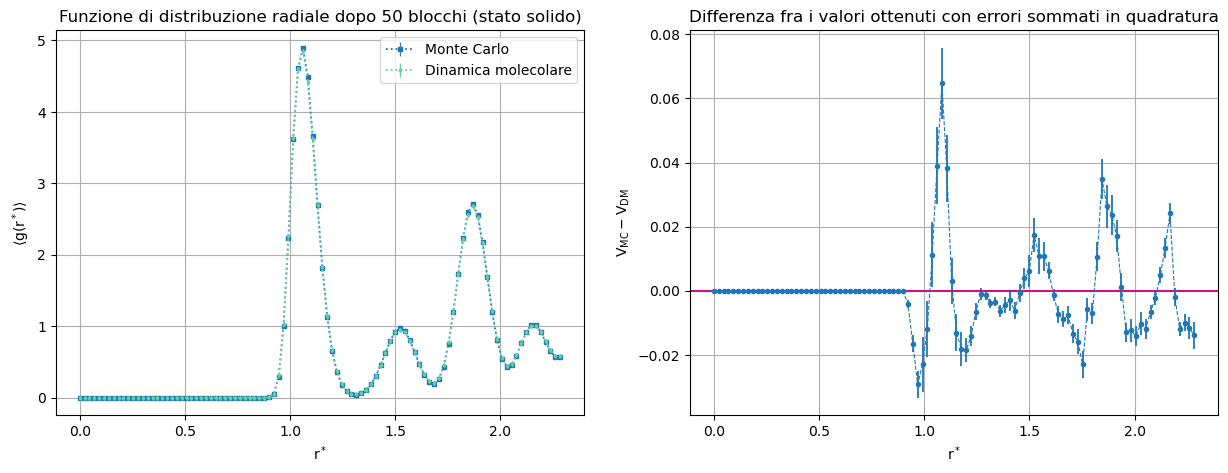

In [9]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
sol_xgofr1, sol_gofr1, sol_err1=np.loadtxt("SolidState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
sol_xgofr0, sol_gofr0, sol_err0=np.loadtxt("SolidState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

sgfig ,(sgplt1, sgplt2) = plt.subplots(1, 2, figsize=(15, 5))

sgplt1.errorbar(sol_xgofr1, sol_gofr1, yerr=sol_err1, marker='s', linestyle=':', elinewidth=1, ecolor="steelblue", markersize=2.5, linewidth=1.3, label="Monte Carlo")
sgplt1.errorbar(sol_xgofr0, sol_gofr0, yerr=sol_err0, marker='d', linestyle=':', elinewidth=1, markersize=2, linewidth=1.3, label="Dinamica molecolare", color="mediumaquamarine")
sgplt1.set_xlabel(r"$\mathrm{r^*}$")
sgplt1.set_ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
sgplt1.set_title("Funzione di distribuzione radiale dopo 50 blocchi (stato solido)")
sgplt1.legend()
sgplt1.grid(True)

sgplt2.errorbar(sol_xgofr1, sol_gofr1-sol_gofr0, yerr=np.sqrt(sol_err1**2 + sol_err0**2), linestyle='--', marker='.', elinewidth=1.3, linewidth=0.8)
sgplt2.axhline(y=0, color="mediumvioletred")
sgplt2.set_xlabel(r"$\mathrm{r^*}$")
sgplt2.set_ylabel(r"$\mathrm{V_{MC}-V_{DM}}$")
sgplt2.set_title("Differenza fra i valori ottenuti con errori sommati in quadratura")
sgplt2.grid(True)

plt.show()

Ricordati di spiegare il senso del secondo grafico: è solo per far vedere bene che i due metodi danno risultati molto simili ma non uguali evitando una sbagliata lettura del primo grafico. Ovviamente plottare la differenza serve a dare un'idea di massima, io sto usando errori statistici che man mano che aumento la statistica diminuiscono ergo se sembra che i due metodi non siano compatibili è solo perchè appunto le statistiche son buone ergo hanno errori molto piccoli. Non ho normalizzato la differenza come avrebbe senso fare perchè poi la propagazione dell'errore è difficilissima. Specifica che un plot simile ha proprio un significato diverso rispetto a tipo quelli del random walk o di ising che invece erano confronti fra dati e valore atteso.

# Stato liquido

## Data blocking e autocorrelazione 

In [10]:
liq_inst=np.loadtxt("LiquidState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

In [11]:
liq_ac=np.empty(len(ts))
for i in range(len(ts)):
    liq_ac[i]=AutoCorr(liq_inst, ts[i])

In [12]:
liq_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    liq_error[i]=BlockAnalysis(liq_inst, Ls[i])

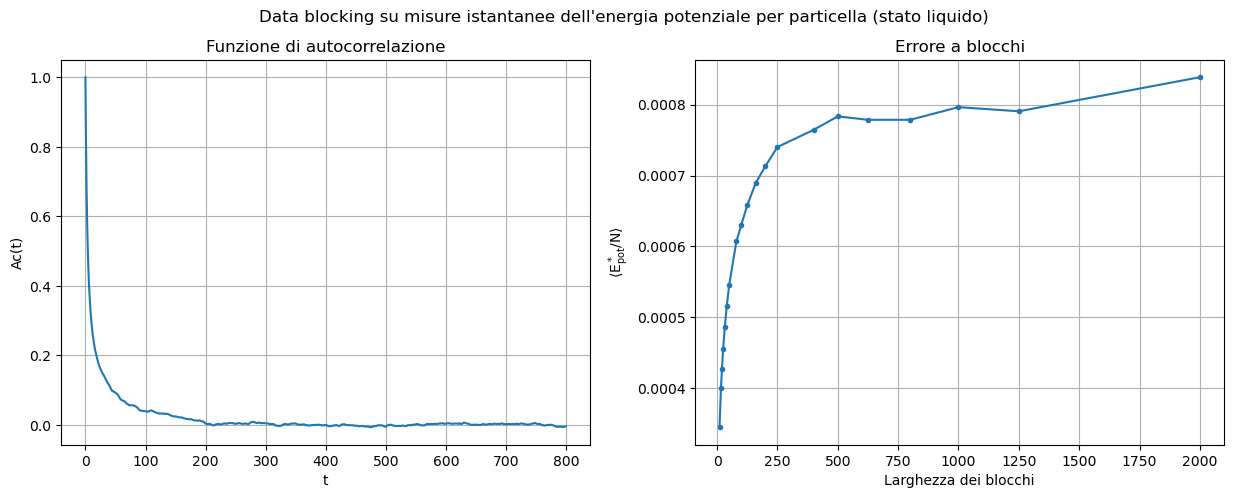

In [27]:
lbfig ,(lbplt1, lbplt2) = plt.subplots(1, 2, figsize=(15, 5))

lbplt1.plot(ts, liq_ac)
lbplt1.set_xlabel("t")
lbplt1.set_ylabel("Ac(t)")
lbplt1.set_title("Funzione di autocorrelazione")
lbplt1.grid(True)

lbplt2.plot(Ls[:20], liq_error[:20], marker='.')
lbplt2.set_xlabel("Larghezza dei blocchi")
lbplt2.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
lbplt2.set_title("Errore a blocchi")
lbplt2.grid(True)

lbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato liquido)")
plt.show()

## Gofr

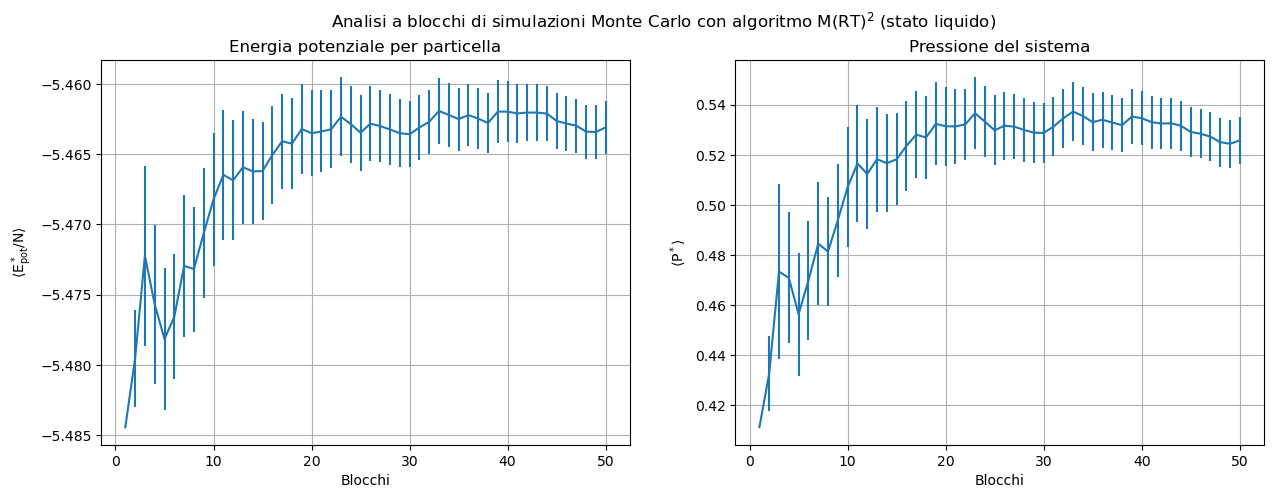

In [14]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
liq_en, liq_en_err=np.loadtxt("LiquidState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
liq_pres, liq_pres_err=np.loadtxt("LiquidState/pressure.dat", usecols=(2, 3), unpack="true")

lmfig ,(lmplt1, lmplt2) = plt.subplots(1, 2, figsize=(15, 5))

lmplt1.errorbar(xbl, liq_en, yerr=liq_en_err)
lmplt1.set_xlabel("Blocchi")
lmplt1.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
lmplt1.set_title("Energia potenziale per particella")
lmplt1.grid(True)

lmplt2.errorbar(xbl, liq_pres, yerr=liq_pres_err)
lmplt2.set_xlabel("Blocchi")
lmplt2.set_ylabel(r"$\langle \mathrm{P^*} \rangle$")
lmplt2.set_title("Pressione del sistema")
lmplt2.grid(True)

lmfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato liquido)")
plt.show()

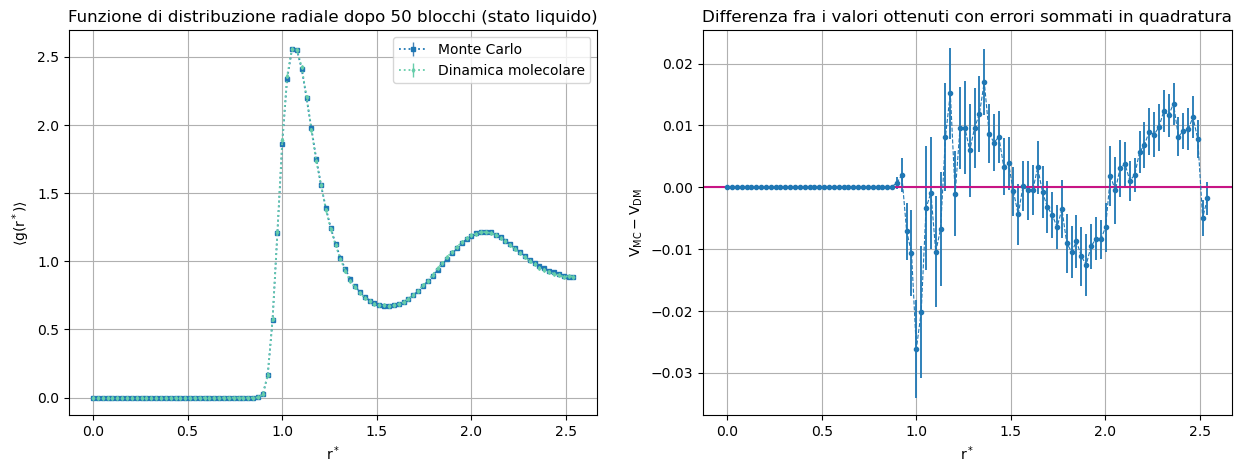

In [15]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
liq_xgofr1, liq_gofr1, liq_err1=np.loadtxt("LiquidState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
liq_xgofr0, liq_gofr0, liq_err0=np.loadtxt("LiquidState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

lgfig ,(lgplt1, lgplt2) = plt.subplots(1, 2, figsize=(15, 5))

lgplt1.errorbar(liq_xgofr1, liq_gofr1, yerr=liq_err1, marker='s', linestyle=':', elinewidth=1, ecolor="steelblue", markersize=2.5, linewidth=1.3, label="Monte Carlo")
lgplt1.errorbar(liq_xgofr0, liq_gofr0, yerr=liq_err0, marker='d', linestyle=':', elinewidth=1, markersize=2, linewidth=1.3, label="Dinamica molecolare", color="mediumaquamarine")
lgplt1.set_xlabel(r"$\mathrm{r^*}$")
lgplt1.set_ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
lgplt1.set_title("Funzione di distribuzione radiale dopo 50 blocchi (stato liquido)")
lgplt1.legend()
lgplt1.grid(True)

lgplt2.errorbar(liq_xgofr1, liq_gofr1-liq_gofr0, yerr=np.sqrt(liq_err1**2 + liq_err0**2), linestyle='--', marker='.', elinewidth=1.3, linewidth=0.8)
lgplt2.axhline(y=0, color="mediumvioletred")
lgplt2.set_xlabel(r"$\mathrm{r^*}$")
lgplt2.set_ylabel(r"$\mathrm{V_{MC}-V_{DM}}$")
lgplt2.set_title("Differenza fra i valori ottenuti con errori sommati in quadratura")
lgplt2.grid(True)

plt.show()

# Stato gassoso

## Data blocking e autocorrelazione

L'accettazione resta al 60% e non scende oltre perchè la fase gassosa è molto diluita ergo devo allargare un po' la delta per abbassare accettazione, ma se allargo troppo inizio ad uscire dal box ergo per periodic boundary conditions torno alla mia posizione di partenza e dunque l'accettazione non può scendere. Ergo alla fine questa analisi fatta con $\delta = 3.5$ che è il primo valore per cui sono a circa 60% di accettazione e l'ultimo valore per cui ancora cambia l'accettazione.

In [16]:
gas_eq=np.loadtxt("GasState/eq_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati
gas_inst=np.loadtxt("GasState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

In [18]:
gas_ac=np.empty(len(ts))
for i in range(len(ts)):
    gas_ac[i]=AutoCorr(gas_inst, ts[i])

In [19]:
gas_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    gas_error[i]=BlockAnalysis(gas_inst, Ls[i])

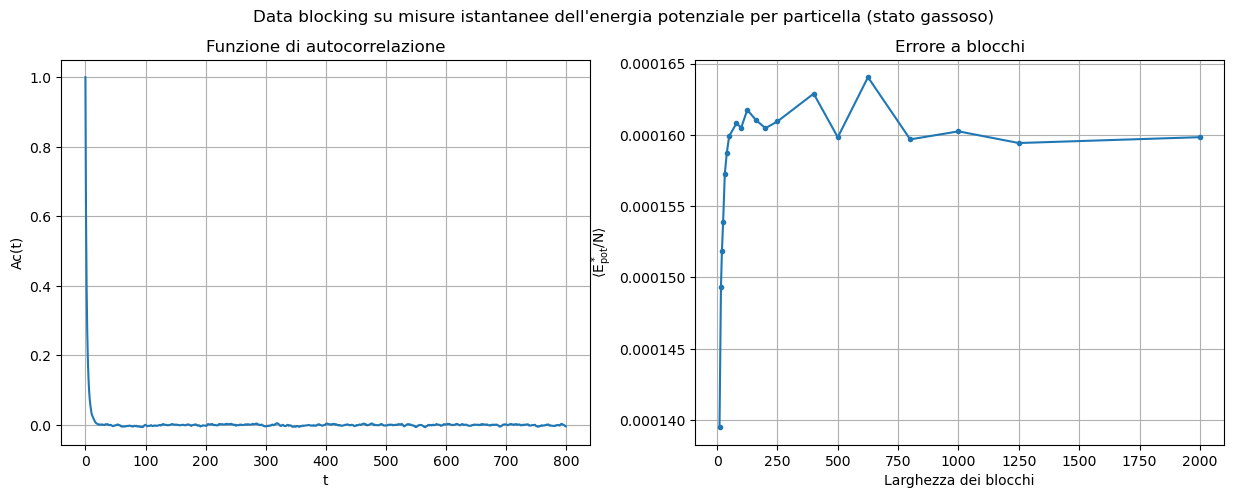

In [28]:
gbfig ,(gbplt1, gbplt2) = plt.subplots(1, 2, figsize=(15, 5))

gbplt1.plot(ts, gas_ac)
gbplt1.set_xlabel("t")
gbplt1.set_ylabel("Ac(t)")
gbplt1.set_title("Funzione di autocorrelazione")
gbplt1.grid(True)

gbplt2.plot(Ls[:20], gas_error[:20], marker='.')
gbplt2.set_xlabel("Larghezza dei blocchi")
gbplt2.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
gbplt2.set_title("Errore a blocchi")
gbplt2.grid(True)

gbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato gassoso)")
plt.show()

## Gofr

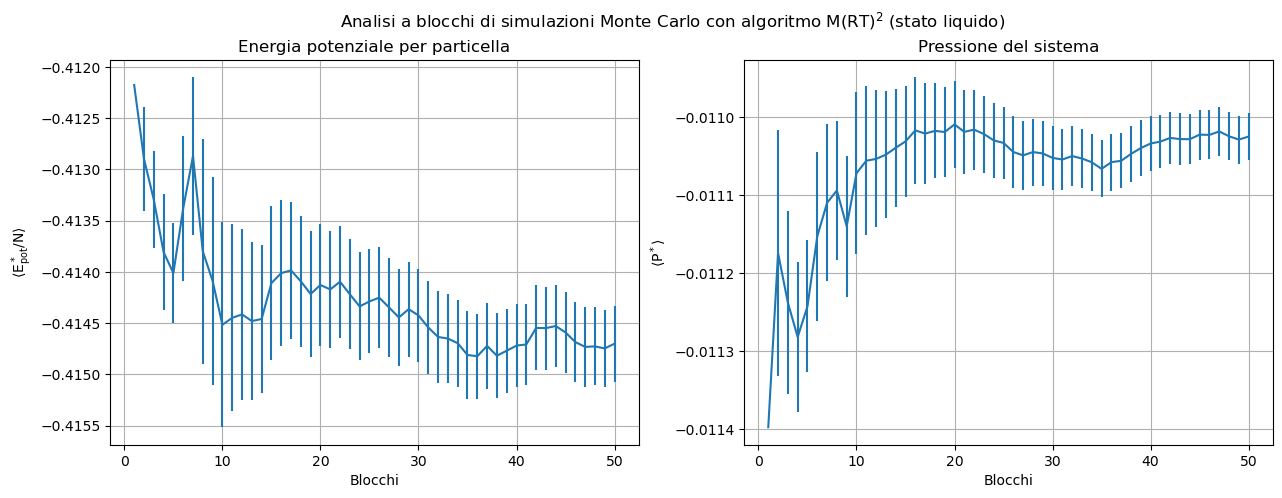

In [29]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
gas_en, gas_en_err=np.loadtxt("GasState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
gas_pres, gas_pres_err=np.loadtxt("GasState/pressure.dat", usecols=(2, 3), unpack="true")

gmfig ,(gmplt1, gmplt2) = plt.subplots(1, 2, figsize=(15, 5))

gmplt1.errorbar(xbl, gas_en, yerr=gas_en_err)
gmplt1.set_xlabel("Blocchi")
gmplt1.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
gmplt1.set_title("Energia potenziale per particella")
gmplt1.grid(True)

gmplt2.errorbar(xbl, gas_pres, yerr=gas_pres_err)
gmplt2.set_xlabel("Blocchi")
gmplt2.set_ylabel(r"$\langle \mathrm{P^*} \rangle$")
gmplt2.set_title("Pressione del sistema")
gmplt2.grid(True)

gmfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato liquido)")
plt.show()

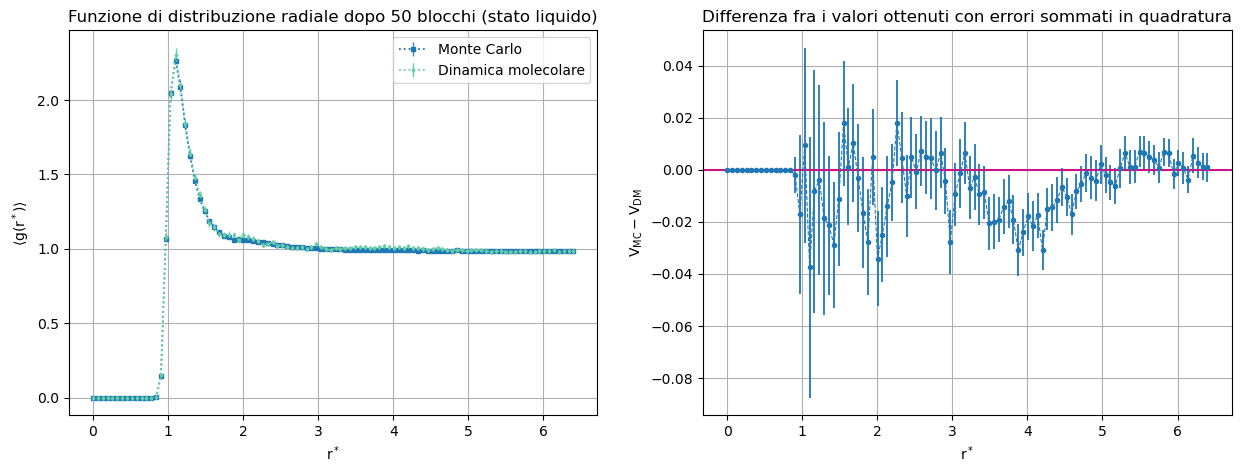

In [30]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
gas_xgofr1, gas_gofr1, gas_err1=np.loadtxt("GasState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
gas_xgofr0, gas_gofr0, gas_err0=np.loadtxt("GasState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

ggfig ,(ggplt1, ggplt2) = plt.subplots(1, 2, figsize=(15, 5))

ggplt1.errorbar(gas_xgofr1, gas_gofr1, yerr=gas_err1, marker='s', linestyle=':', elinewidth=1, ecolor="steelblue", markersize=2.5, linewidth=1.3, label="Monte Carlo")
ggplt1.errorbar(gas_xgofr0, gas_gofr0, yerr=gas_err0, marker='d', linestyle=':', elinewidth=1, markersize=2, linewidth=1.3, label="Dinamica molecolare", color="mediumaquamarine")
ggplt1.set_xlabel(r"$\mathrm{r^*}$")
ggplt1.set_ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
ggplt1.set_title("Funzione di distribuzione radiale dopo 50 blocchi (stato liquido)")
ggplt1.legend()
ggplt1.grid(True)

ggplt2.errorbar(gas_xgofr1, gas_gofr1-gas_gofr0, yerr=np.sqrt(gas_err1**2 + gas_err0**2), linestyle='--', marker='.', elinewidth=1.3, linewidth=0.8)
ggplt2.axhline(y=0, color="mediumvioletred")
ggplt2.set_xlabel(r"$\mathrm{r^*}$")
ggplt2.set_ylabel(r"$\mathrm{V_{MC}-V_{DM}}$")
ggplt2.set_title("Differenza fra i valori ottenuti con errori sommati in quadratura")
ggplt2.grid(True)

plt.show()